In [1]:
%reset

In [47]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from model.hnn import HNN
from model.args import UpdatableNamespace

In [48]:
alpha = 0.5

In [49]:
def mass_spring(y, args, kargs):
    q = y[:, 0]
    p = y[:, 1]
    dq_dt = p
    dp_dt = -q
    return torch.stack((dq_dt, dp_dt), dim=-1)

In [50]:
def double_well(y, args, kargs):
    q = y[:, 0]
    p = y[:, 1]
    dq_dt = p
    dp_dt = q - q**3
    return torch.stack((dq_dt, dp_dt), dim=-1)

In [51]:
def henon_heiles(y, args, kargs):
    q1, q2, p1, p2 = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
    
    dq1 = p1
    dq2 = p2
    dp1 = -q1 - 2 * q1 * q2
    dp2 = -q2 - q1**2 + q2**2
    
    return torch.stack((dq1, dq2, dp1, dp2), dim=-1)

In [52]:
# Dynamics for the non-separable Hamiltonian system
def coupled_ho(y, args, kargs):
    #alpha = args
    #alpha = 0.5
    q, p = y[:, 0], y[:, 1]
    dqdt = p + alpha * q
    dpdt = -q - alpha * p
    return torch.stack((dqdt, dpdt), dim=-1)

In [53]:
import torch
import math

In [54]:
# ==== Load the trained full model ====
#model_path = "models/model_0_double_well_0.01_im.pt"
model_path = "models/model_0_coupled_ho_0.01_im.pt"
#model_path = "models/model_0_henon_heiles_0.01_im.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_path, map_location=device)
model.eval()


/tmp/ipykernel_27971/2886186125.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


HNN(
  (differentiable_model): MLP(
    (layer0): Linear(in_features=2, out_features=100, bias=True)
    (layer1): Linear(in_features=100, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=1, bias=False)
  )
)

In [55]:
def H_pred(y_tensor: torch.Tensor, args: tuple, kargs: dict) -> torch.Tensor:
    """
    y_tensor: [B,2N] concatenation of q,p
    args: (model,)
    returns: [B] the scalar Hamiltonian for each sample
    """
    model = args[0]
    with torch.no_grad():
        H = model.cal_H(y_tensor).squeeze(-1)  # [B]
    return H

### HERE GOES ###

In [56]:
def h_pred_fn(Y: torch.Tensor) -> torch.Tensor:
    """
    Y: [N, 2] tensor where each row is (q, p).
    Returns: [N] tensor of model-predicted H(q,p).
    """
    with torch.no_grad():
        # If your model’s forward returns H as shape [N],
        # you can just call model(Y).  Otherwise, if you need
        # to call your .cal_H submodule directly, do that instead.
        H = model(Y)              # → [N]
    return H

In [57]:
import numpy as np
import torch

def _evaluate_batch(
    Y,
    model,
    forward_ode,
    true_dyn_fn,
    true_dyn_args=(),
    true_dyn_kwargs=None,
    true_h_fn=None,
):
    """
    Evaluate model vs ground truth on the batch Y (shape (N,2)).
    - forward_ode(Y, (model,), (0,)) → Tensor (N,2)
    - true_dyn_fn(Y, *true_dyn_args, **true_dyn_kwargs) → Tensor (N,2)
    - true_h_fn(q_array, p_array) → numpy (N,)
    """
    if true_dyn_kwargs is None:
        true_dyn_kwargs = {}

    # 1) Model predictions
    with torch.no_grad():
        pred_dyn = (
            forward_ode(Y, (model,), (0,))
            .detach()
            .cpu()
            .numpy()
        )  # (N,2)
        pred_h = (
            model(Y)
            .squeeze()
            .detach()
            .cpu()
            .numpy()
        )  # (N,)

    # 2) True dynamics (allow extra args/kwargs)
    true_dyn = (
        true_dyn_fn(Y, *true_dyn_args, **true_dyn_kwargs)
        .detach()
        .cpu()
        .numpy()
    )  # (N,2)

    # 3) True Hamiltonian
    q = Y[:, 0].cpu().numpy()
    p = Y[:, 1].cpu().numpy()
    if true_h_fn is None:
        raise ValueError("Please supply true_h_fn(q,p) → numpy array")
    true_h = true_h_fn(q, p)  # (N,)

    # 4) Offset correction & errors
    offset = np.mean(pred_h - true_h)
    pred_h_corr = pred_h - offset

    h_err = np.abs(pred_h_corr - true_h)
    mean_abs_h = float(h_err.mean())

    dq_err = true_dyn[:, 0] - pred_dyn[:, 0]
    dp_err = true_dyn[:, 1] - pred_dyn[:, 1]

    return {
        "pred_dyn":    pred_dyn,
        "true_dyn":    true_dyn,
        "pred_h":      pred_h,
        "true_h":      true_h,
        "offset":      offset,
        "pred_h_corr": pred_h_corr,
        "h_error":     h_err,
        "mean_abs_h":  mean_abs_h,
        "dq_error":    dq_err,
        "dp_error":    dp_err,
    }

In [58]:
def evaluate_on_uniform_grid(
    h_pred_fn,          # callable: H_pred = h_pred_fn(Y) → shape (N,)
    true_h_fn,          # callable: H_true = true_h_fn(q_array, p_array) → shape (N,)
    num_pts=30,
    xlim=(-2, 2),
    ylim=(-2, 2),
    device="cpu",
):
    """
    Sample a num_pts×num_pts grid over [xlim]×[ylim], compute
      H_pred, H_true, offset‐corrected H_pred, and absolute error.
    Returns dict with:
      Q, P          meshgrid arrays shape (num_pts,num_pts)
      pred_h        shape (num_pts,num_pts)
      true_h        shape (num_pts,num_pts)
      pred_h_corr   shape (num_pts,num_pts)
      h_error       shape (num_pts,num_pts)
      offset        float
      mean_abs_h    float
    """
    # 1) build grid
    qv = np.linspace(xlim[0], xlim[1], num_pts)
    pv = np.linspace(ylim[0], ylim[1], num_pts)
    Q, P = np.meshgrid(qv, pv, indexing="xy")
    pts = np.stack([Q.ravel(), P.ravel()], axis=1)           # (N,2)
    Y   = torch.tensor(pts, dtype=torch.float32, device=device)

    # 2) predicted H
    with torch.no_grad():
        pred_h = h_pred_fn(Y)                                # (N,)
        pred_h = pred_h.detach().cpu().numpy()

    # 3) true H
    q = pts[:, 0]
    p = pts[:, 1]
    true_h = true_h_fn(q, p)                                 # (N,)

    # 4) offset correction + error
    offset      = np.mean(pred_h - true_h)
    pred_h_corr = pred_h - offset
    h_error     = np.abs(pred_h_corr - true_h)
    mean_abs_h  = float(h_error.mean())

    # 5) reshape back to grid
    out = {
        "Q": Q,
        "P": P,
        "pred_h":      pred_h.reshape(num_pts, num_pts),
        "true_h":      true_h.reshape(num_pts, num_pts),
        "pred_h_corr": pred_h_corr.reshape(num_pts, num_pts),
        "h_error":     h_error.reshape(num_pts, num_pts),
        "offset":      offset,
        "mean_abs_h":  mean_abs_h,
    }
    return out

In [59]:
def evaluate_on_random_uniform(
    h_pred_fn,          # callable: H_pred = h_pred_fn(Y) → shape (N,)
    true_h_fn,          # callable: H_true = true_h_fn(q_array, p_array) → shape (N,)
    num_samples=1000,
    xlim=(-2, 2),
    ylim=(-2, 2),
    device="cpu",
):
    """
    Sample num_samples points uniformly in [xlim]×[ylim],
    compute H_pred, H_true, etc.  Returns raw 1D arrays plus coords.
    """
    # 1) sample coords
    q = np.random.uniform(xlim[0], xlim[1], size=num_samples)
    p = np.random.uniform(ylim[0], ylim[1], size=num_samples)
    pts = np.column_stack([q, p])                           # (N,2)
    Y   = torch.tensor(pts, dtype=torch.float32, device=device)

    # 2) predicted H
    with torch.no_grad():
        pred_h = h_pred_fn(Y).detach().cpu().numpy()        # (N,)

    # 3) true H
    true_h = true_h_fn(q, p)                                # (N,)

    # 4) offset + error
    offset      = np.mean(pred_h - true_h)
    pred_h_corr = pred_h - offset
    h_error     = np.abs(pred_h_corr - true_h)
    mean_abs_h  = float(h_error.mean())

    return {
        "coords":      pts,        # (N,2)
        "pred_h":      pred_h,     # (N,)
        "true_h":      true_h,     # (N,)
        "pred_h_corr": pred_h_corr,# (N,)
        "h_error":     h_error,    # (N,)
        "offset":      offset,
        "mean_abs_h":  mean_abs_h,
    }


In [60]:
def evaluate_on_gaussian(
    h_pred_fn,          # callable: H_pred = h_pred_fn(Y) → shape (N,)
    true_h_fn,          # callable: H_true = true_h_fn(q_array, p_array) → shape (N,)
    num_samples=1000,
    mean=(0, 0),
    cov=[[1, 0], [0, 1]],
    device="cpu",
):
    """
    Sample num_samples points from N(mean, cov),
    compute H_pred, H_true, etc.  Returns raw 1D arrays plus coords.
    """
    # 1) sample coords
    pts = np.random.multivariate_normal(mean, cov, size=num_samples)  # (N,2)
    Y   = torch.tensor(pts, dtype=torch.float32, device=device)

    # 2) predicted H
    with torch.no_grad():
        pred_h = h_pred_fn(Y).detach().cpu().numpy()                    # (N,)

    # 3) true H
    q = pts[:, 0]
    p = pts[:, 1]
    true_h = true_h_fn(q, p)                                          # (N,)

    # 4) offset + error
    offset      = np.mean(pred_h - true_h)
    pred_h_corr = pred_h - offset
    h_error     = np.abs(pred_h_corr - true_h)
    mean_abs_h  = float(h_error.mean())

    return {
        "coords":      pts,        # (N,2)
        "pred_h":      pred_h,     # (N,)
        "true_h":      true_h,     # (N,)
        "pred_h_corr": pred_h_corr,# (N,)
        "h_error":     h_error,    # (N,)
        "offset":      offset,
        "mean_abs_h":  mean_abs_h,
    }

In [66]:
def true_h_fn(q,p):
    #return 0.5*p**2 + 0.25*q**4 - 0.5*q**2
    return 0.5*p**2 + 0.5*q**2 + alpha*p*q

# Wrap double_well so it gets the two None arguments
def true_dyn_fn(Y, args=None, kargs=None):
    #return double_well(Y, args, kargs)
    return coupled_ho(Y, args=None, kargs=None)

In [67]:
# 1) Uniform grid evaluation (only Hamiltonian)
res_grid = evaluate_on_uniform_grid(
    h_pred_fn,        # predicted H(Y) → Tensor[N×N]
    true_h_fn,        # true H(q,p) → array[N×N]
    num_pts=30,
    xlim=(-2, 2),
    ylim=(-2, 2),
    device=device
)

In [68]:
# 2) Uniform random sampling evaluation
res_rand = evaluate_on_random_uniform(
    h_pred_fn,       # H_pred(Y) → Tensor[num_samples]
    true_h_fn,       # true_h(q,p) → array[num_samples]
    num_samples=100000,
    xlim=(-2, 2),
    ylim=(-2, 2),
    device='cpu'
)
q_rand, p_rand = res_rand["coords"].T    # shape (2000,)
h_error_rand   = res_rand["h_error"]     # shape (2000,)

In [69]:
# 3) Gaussian sampling evaluation
res_gauss = evaluate_on_gaussian(
    h_pred_fn,       # H_pred(Y) → Tensor[num_samples]
    true_h_fn,       # true_h(q,p) → array[num_samples]
    num_samples=100000,
    mean=(0, 0),
    cov=[[1, 0], [0, 1]],
    device='cpu'
)
q_gauss, p_gauss = res_gauss["coords"].T
h_error_gauss    = res_gauss["h_error"]

In [70]:
print(res_rand["h_error"].mean())
print(res_grid["h_error"].mean())
print(res_gauss["h_error"].mean())

0.012936176110885458
0.01330284221168866
0.016671243584603253


In [72]:
mean_rand = res_rand["h_error"].mean()
sem_rand = res_rand["h_error"].std(ddof=1) / np.sqrt(len(res_rand["h_error"]))
print(f"Mean ± SEM: {mean_rand:.3f} ± {sem_rand:.5f}")

mean_grid = res_grid["h_error"].mean()
sem_grid = res_grid["h_error"].std(ddof=1) / np.sqrt(len(res_grid["h_error"]))
print(f"Mean ± SEM: {mean_grid:.3f} ± {sem_grid:.5f}")

mean_gauss = res_gauss["h_error"].mean()
sem_gauss = res_gauss["h_error"].std(ddof=1) / np.sqrt(len(res_gauss["h_error"]))
print(f"Mean ± SEM: {mean_gauss:.3f} ± {sem_gauss:.5f}")

Mean ± SEM: 0.013 ± 0.00003
Mean ± SEM: 0.013 ± 0.00168
Mean ± SEM: 0.017 ± 0.00016


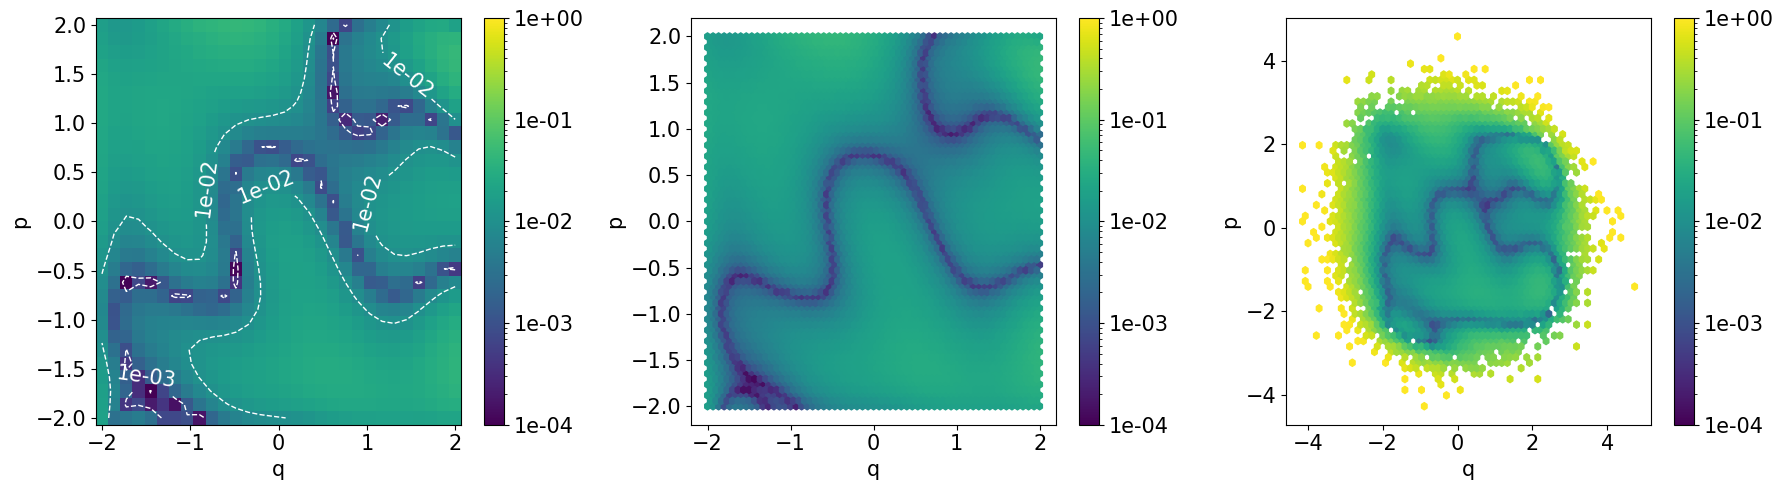

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, FuncFormatter, ScalarFormatter

# shared settings
levels     = [1e-4, 1e-3, 1e-2, 1e-1, 1]
norm       = LogNorm(vmin=levels[0], vmax=levels[-1])
cbar_ticks = LogLocator(base=10, subs=[1], numticks=len(levels))
fontsize   = 15

# unpack your data
Q, P    = res_grid["Q"], res_grid["P"]
h_grid  = res_grid["h_error"]
q_rand, p_rand   = res_rand["coords"].T
h_rand           = res_rand["h_error"]
q_gauss, p_gauss = res_gauss["coords"].T
h_gauss          = res_gauss["h_error"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: grid + contours
ax = axes[0]
pcm = ax.pcolormesh(Q, P, h_grid,
                    shading="auto", cmap="viridis",
                    norm=norm)
cs = ax.contour(Q, P, h_grid,
                levels=levels,
                colors="white",
                linestyles="--",
                linewidths=1.0)
ax.clabel(cs, fmt=lambda v: f"{v:.0e}",
          inline=True, fontsize=fontsize, colors="white")

#ax.set_title("Grid $|H_{pred}-H_{true}|$", fontsize=fontsize)
ax.set_xlabel("q", fontsize=fontsize)
ax.set_ylabel("p", fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)

cbar = fig.colorbar(pcm, ax=ax, ticks=cbar_ticks)
cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0e}"))
cbar.ax.tick_params(labelsize=fontsize)

# Panel 2: uniform-random, no contours
ax = axes[1]
hb1 = ax.hexbin(q_rand, p_rand, C=h_rand,
                gridsize=60, cmap="viridis", norm=norm)
#ax.set_title("Uniform‐Random $|H_{pred}-H_{true}|$", fontsize=fontsize)
ax.set_xlabel("q", fontsize=fontsize)
ax.set_ylabel("p", fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)

cbar1 = fig.colorbar(hb1, ax=ax, ticks=cbar_ticks)
cbar1.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cbar1.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0e}"))
cbar1.ax.tick_params(labelsize=fontsize)

# Panel 3: gaussian, no contours
ax = axes[2]
hb2 = ax.hexbin(q_gauss, p_gauss, C=h_gauss,
                gridsize=60, cmap="viridis", norm=norm)
#ax.set_title("Gaussian $|H_{pred}-H_{true}|$", fontsize=fontsize)
ax.set_xlabel("q", fontsize=fontsize)
ax.set_ylabel("p", fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)

cbar2 = fig.colorbar(hb2, ax=ax, ticks=cbar_ticks)
cbar2.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cbar2.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0e}"))
cbar2.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()


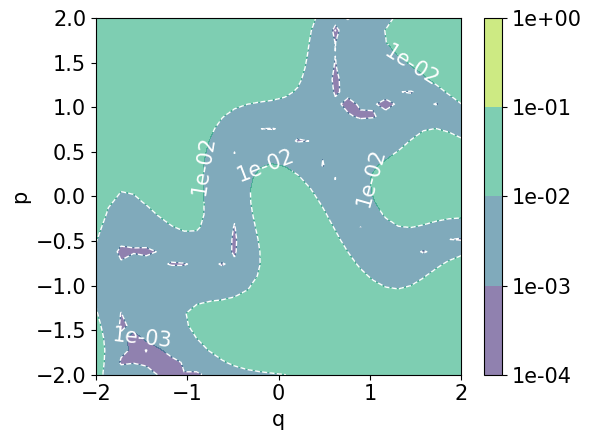

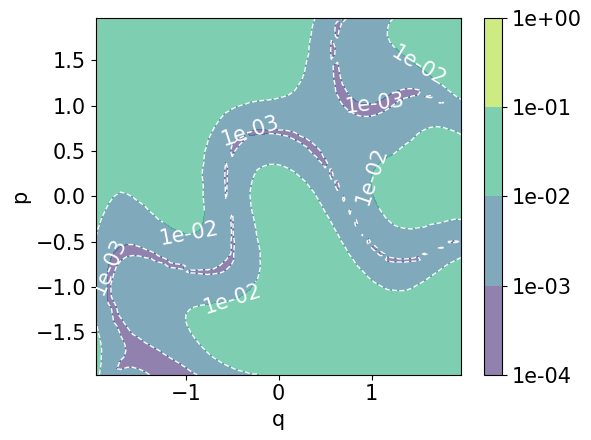

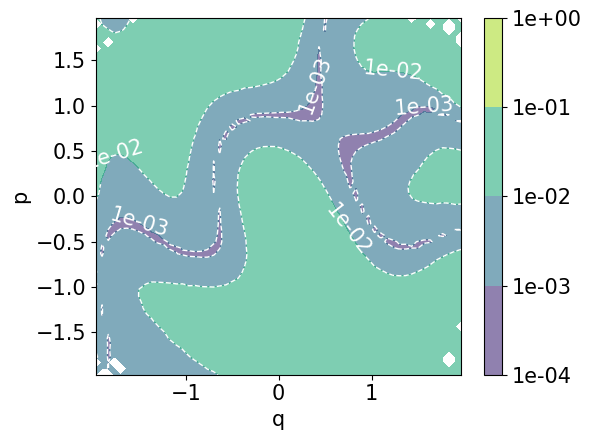

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter
from scipy.stats import binned_statistic_2d

# ---------------------------------------------------
# Shared settings
# ---------------------------------------------------
bands      = [1e-4, 1e-3, 1e-2, 1e-1, 1]
fontsize   = 15
norm       = LogNorm(vmin=bands[0], vmax=bands[-1])
cbar_fmt   = ScalarFormatter(useMathText=True)
cbar_ticks = bands

# ---------------------------------------------------
# Helper: bin (q,p,h) onto a grid for contouring
# ---------------------------------------------------
def compute_binned_mean(q, p, h, bins=60, range=[[-2,2],[-2,2]]):
    stat, xe, ye, _ = binned_statistic_2d(
        q, p, h, statistic="mean",
        bins=bins, range=range
    )
    xc = (xe[:-1] + xe[1:]) / 2
    yc = (ye[:-1] + ye[1:]) / 2
    return stat.T, np.meshgrid(xc, yc)

# ---------------------------------------------------
# Unpack your data
# ---------------------------------------------------
# 1) Uniform grid
Q, P       = res_grid["Q"], res_grid["P"]
h_grid     = res_grid["h_error"]

# 2) Uniform-random
coords_rand = res_rand["coords"]
q_rand, p_rand = coords_rand.T
h_rand       = res_rand["h_error"]
stat_rand, (Qr, Pr) = compute_binned_mean(q_rand, p_rand, h_rand)

# 3) Gaussian
coords_gauss = res_gauss["coords"]
q_gauss, p_gauss = coords_gauss.T
h_gauss        = res_gauss["h_error"]
stat_gauss, (Qg, Pg) = compute_binned_mean(q_gauss, p_gauss, h_gauss)

# ---------------------------------------------------
# Plot 1: Grid data with discrete filled bands
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4.5))
cf = ax.contourf(
    Q, P, h_grid,
    levels=bands,
    cmap='viridis',
    norm=norm,
    alpha=0.6
)
cs = ax.contour(
    Q, P, h_grid,
    levels=bands,
    colors='white',
    linestyles='--',
    linewidths=1.0
)
ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors='white')

#ax.set_title("Grid $|H_{pred}-H_{true}|$ bands", fontsize=fontsize)
ax.set_xlabel("q", fontsize=fontsize)
ax.set_ylabel("p", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

cbar = plt.colorbar(cf, ax=ax, ticks=cbar_ticks, format=cbar_fmt)
cbar.ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0e}")
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()

# ---------------------------------------------------
# Plot 2: Uniform‐random data with discrete filled bands
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4.5))
cf = ax.contourf(
    Qr, Pr, stat_rand,
    levels=bands,
    cmap='viridis',
    norm=norm,
    alpha=0.6
)
cs = ax.contour(
    Qr, Pr, stat_rand,
    levels=bands,
    colors='white',
    linestyles='--',
    linewidths=1.0
)
ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors='white')

#ax.set_title("Uniform‐Random $|H_{pred}-H_{true}|$ bands", fontsize=fontsize)
ax.set_xlabel("q", fontsize=fontsize)
ax.set_ylabel("p", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

cbar = plt.colorbar(cf, ax=ax, ticks=cbar_ticks, format=cbar_fmt)
cbar.ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0e}")
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()

# ---------------------------------------------------
# Plot 3: Gaussian data with discrete filled bands
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4.5))
cf = ax.contourf(
    Qg, Pg, stat_gauss,
    levels=bands,
    cmap='viridis',
    norm=norm,
    alpha=0.6
)
cs = ax.contour(
    Qg, Pg, stat_gauss,
    levels=bands,
    colors='white',
    linestyles='--',
    linewidths=1.0
)
ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors='white')

#ax.set_title("Gaussian $|H_{pred}-H_{true}|$ bands", fontsize=fontsize)
ax.set_xlabel("q", fontsize=fontsize)
ax.set_ylabel("p", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

cbar = plt.colorbar(cf, ax=ax, ticks=cbar_ticks, format=cbar_fmt)
cbar.ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0e}")
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()


### For Henon Heiles ###

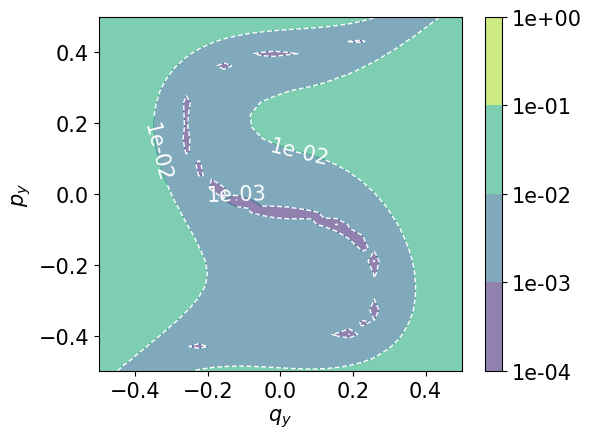

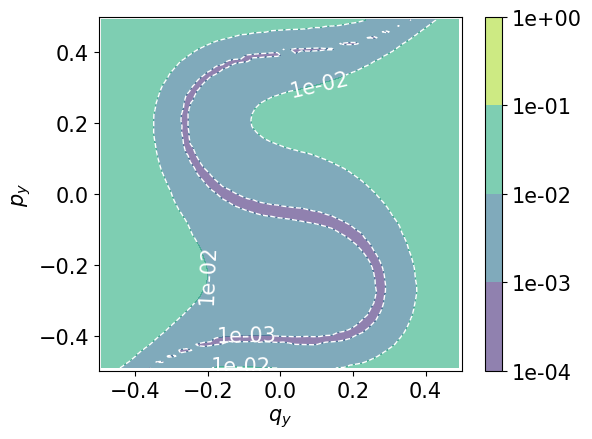

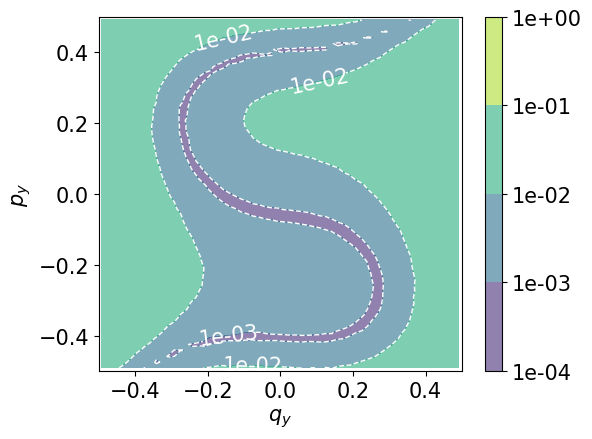

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from scipy.stats import binned_statistic_2d

# ---------- true Hamiltonian and dynamics helpers ----------
def true_h_point_full(Y: torch.Tensor) -> np.ndarray:
    """
    Y: [N,4] rows [q_x, q_y, p_x, p_y]
    returns: (N,) true H = 0.5*(p_x^2+p_y^2)+0.5*(q_x^2+q_y^2)+q_x^2 q_y - (q_y^3)/3
    """
    y_np = Y.cpu().numpy()
    qx = y_np[:, 0]
    qy = y_np[:, 1]
    px = y_np[:, 2]
    py = y_np[:, 3]
    return 0.5 * (px**2 + py**2) + 0.5 * (qx**2 + qy**2) + (qx**2) * qy - (qy**3) / 3.0

# ---------- your H_pred_fn: model must be in scope ----------
def H_pred_fn_full(Y: torch.Tensor) -> torch.Tensor:
    """
    Y: [N,4] tensor: [q_x, q_y, p_x, p_y]
    returns: [N] predicted H
    """
    with torch.no_grad():
        # adapt depending on your model: either model(Y) or model.cal_H(Y)
        H = model(Y).squeeze()
        # Or if using HNN: H = model(Y)
    return H  # shape [N]

# ---------- slice over (q_y, p_y) at fixed qx, px ----------
def slice_and_plot(qx_fixed, px_fixed, num_pts=100, band_levels=None):
    if band_levels is None:
        band_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1]
    norm = LogNorm(vmin=band_levels[0], vmax=band_levels[-1])
    fontsize = 15

    # Build grid over qy, py
    qy_vals = np.linspace(-0.5, 0.5, num_pts)
    py_vals = np.linspace(-0.5, 0.5, num_pts)
    Qy, Py = np.meshgrid(qy_vals, py_vals, indexing="xy")  # shape (num_pts,num_pts)

    # Construct full input [qx, qy, px, py] flattened
    qx_arr = np.full((num_pts * num_pts,), qx_fixed, dtype=np.float32)
    px_arr = np.full((num_pts * num_pts,), px_fixed, dtype=np.float32)
    qy_flat = Qy.ravel().astype(np.float32)
    py_flat = Py.ravel().astype(np.float32)
    Y = torch.tensor(
        np.stack([qx_arr, qy_flat, px_arr, py_flat], axis=1),
        dtype=torch.float32,
        device="cpu",  # adjust if using GPU
    )  # [M,4]

    # Predict and true H
    H_pred = H_pred_fn_full(Y).cpu().numpy()  # (M,)
    H_true = true_h_point_full(Y)             # (M,)

    # Offset correction
    offset = np.mean(H_pred - H_true)
    H_pred_corr = H_pred - offset
    h_err = np.abs(H_pred_corr - H_true)      # (M,)

    # reshape to grid
    h_error_grid = h_err.reshape(num_pts, num_pts)

    # --- Slice contour plot ---
    fig, ax = plt.subplots(figsize=(6,4.5))
    cf = ax.contourf(
        Qy, Py, h_error_grid,
        levels=band_levels,
        cmap="viridis",
        norm=norm,
        alpha=0.6,
    )
    cs = ax.contour(
        Qy, Py, h_error_grid,
        levels=band_levels,
        colors="white",
        linestyles="--",
        linewidths=1.0,
    )
    ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors="white")
    ax.set_xlabel(r"$q_y$", fontsize=fontsize)
    ax.set_ylabel(r"$p_y$", fontsize=fontsize)
    #ax.set_title(f"Slice at $q_x$={qx_fixed}, $p_x$={px_fixed}", fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(cf, ax=ax, ticks=band_levels, format=ScalarFormatter(useMathText=True))
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0e}"))
    cbar.ax.tick_params(labelsize=fontsize)
    plt.tight_layout()
    plt.show()

    return {
        "Qy": Qy,
        "Py": Py,
        "h_error_grid": h_error_grid,
        "offset": offset,
        "mean_abs_h": float(h_err.mean())
    }

# ---------- binned uniform-random and gaussian over (q_y,p_y) with fixed qx,px ----------
def evaluate_random_and_gauss_slice(qx_fixed, px_fixed, num_samples=100000, bins=60, rng=[[-0.5,0.5],[-0.5,0.5]]):
    # Sample (qy,py) uniformly
    qy_rand = np.random.uniform(rng[0][0], rng[0][1], size=num_samples)
    py_rand = np.random.uniform(rng[1][0], rng[1][1], size=num_samples)

    # Build full inputs
    qx_arr = np.full((num_samples,), qx_fixed, dtype=np.float32)
    px_arr = np.full((num_samples,), px_fixed, dtype=np.float32)
    Y_rand = torch.tensor(
        np.stack([qx_arr, qy_rand, px_arr, py_rand], axis=1),
        dtype=torch.float32,
    )  # [N,4]

    H_pred_rand = H_pred_fn_full(Y_rand).cpu().numpy()
    H_true_rand = true_h_point_full(Y_rand)
    offset_rand = np.mean(H_pred_rand - H_true_rand)
    H_pred_corr_rand = H_pred_rand - offset_rand
    h_err_rand = np.abs(H_pred_corr_rand - H_true_rand)

    stat_rand, xedges, yedges, _ = binned_statistic_2d(
        qy_rand, py_rand, h_err_rand, statistic="mean", bins=bins, range=rng
    )
    xc = (xedges[:-1] + xedges[1:]) / 2
    yc = (yedges[:-1] + yedges[1:]) / 2
    Qr, Pr = np.meshgrid(xc, yc, indexing="xy")

    # Plot
    bands = [1e-4, 1e-3, 1e-2, 1e-1, 1]
    norm = LogNorm(vmin=bands[0], vmax=bands[-1])
    fontsize = 15

    fig, ax = plt.subplots(figsize=(6,4.5))
    cf = ax.contourf(
        Qr, Pr, stat_rand.T,  # transpose for orientation
        levels=bands,
        cmap="viridis",
        norm=norm,
        alpha=0.6,
    )
    cs = ax.contour(
        Qr, Pr, stat_rand.T,
        levels=bands,
        colors="white",
        linestyles="--",
        linewidths=1.0,
    )
    ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors="white")
    ax.set_xlabel(r"$q_y$", fontsize=fontsize)
    ax.set_ylabel(r"$p_y$", fontsize=fontsize)
    #ax.set_title(f"Uniform-random slice at $q_x$={qx_fixed}, $p_x$={px_fixed}", fontsize=fontsize)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(cf, ax=ax, ticks=bands, format=ScalarFormatter(useMathText=True))
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0e}"))
    cbar.ax.tick_params(labelsize=fontsize)
    plt.tight_layout()
    plt.show()

    # Gaussian
    mean = [0, 0]
    cov = [[0.25, 0], [0, 0.25]]  # independent with std=0.5
    qy_gauss, py_gauss = np.random.multivariate_normal(mean, cov, size=num_samples).T
    Y_gauss = torch.tensor(
        np.stack([qx_arr, qy_gauss, px_arr, py_gauss], axis=1),
        dtype=torch.float32,
    )
    H_pred_gauss = H_pred_fn_full(Y_gauss).cpu().numpy()
    H_true_gauss = true_h_point_full(Y_gauss)
    offset_gauss = np.mean(H_pred_gauss - H_true_gauss)
    H_pred_corr_gauss = H_pred_gauss - offset_gauss
    h_err_gauss = np.abs(H_pred_corr_gauss - H_true_gauss)

    stat_gauss, xedges2, yedges2, _ = binned_statistic_2d(
        qy_gauss, py_gauss, h_err_gauss, statistic="mean", bins=bins, range=rng
    )
    xc2 = (xedges2[:-1] + xedges2[1:]) / 2
    yc2 = (yedges2[:-1] + yedges2[1:]) / 2
    Qg, Pg = np.meshgrid(xc2, yc2, indexing="xy")

    fig, ax = plt.subplots(figsize=(6,4.5))
    cf = ax.contourf(
        Qg, Pg, stat_gauss.T,
        levels=bands,
        cmap="viridis",
        norm=norm,
        alpha=0.6,
    )
    cs = ax.contour(
        Qg, Pg, stat_gauss.T,
        levels=bands,
        colors="white",
        linestyles='--',
        linewidths=1.0,
    )
    ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors='white')
    ax.set_xlabel(r"$q_y$", fontsize=fontsize)
    ax.set_ylabel(r"$p_y$", fontsize=fontsize)
    #ax.set_title(f"Gaussian slice at $q_x$={qx_fixed}, $p_x$={px_fixed}", fontsize=fontsize)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(cf, ax=ax, ticks=bands, format=ScalarFormatter(useMathText=True))
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0e}"))
    cbar.ax.tick_params(labelsize=fontsize)
    plt.tight_layout()
    plt.show()

    return {
        "rand": {
            "Qr": Qr,
            "Pr": Pr,
            "stat_rand": stat_rand,
        },
        "gauss": {
            "Qg": Qg,
            "Pg": Pg,
            "stat_gauss": stat_gauss,
        },
    }

# ---------- Example call ----------
slice_res = slice_and_plot(qx_fixed=0.1, px_fixed=0.2, num_pts=30)
rand_gauss_res = evaluate_random_and_gauss_slice(qx_fixed=0.1, px_fixed=0.2, num_samples=100000)

In [25]:
def compute_h_error_from_Y(Y: torch.Tensor):
    """Offset-corrected absolute error vector for given inputs Y."""
    H_pred = H_pred_fn_full(Y).cpu().numpy()
    H_true = true_h_point_full(Y)
    offset = np.mean(H_pred - H_true)
    H_pred_corr = H_pred - offset
    h_err = np.abs(H_pred_corr - H_true)
    return h_err  # flat numpy array

def get_h_error_grid(qx_fixed, px_fixed, num_pts=100):
    """Re-use slice grid logic to get the raw flattened h_error (same domain as slice_and_plot)."""
    qy_vals = np.linspace(-0.5, 0.5, num_pts)
    py_vals = np.linspace(-0.5, 0.5, num_pts)
    Qy, Py = np.meshgrid(qy_vals, py_vals, indexing="xy")
    qx_arr = np.full((num_pts * num_pts,), qx_fixed, dtype=np.float32)
    px_arr = np.full((num_pts * num_pts,), px_fixed, dtype=np.float32)
    qy_flat = Qy.ravel().astype(np.float32)
    py_flat = Py.ravel().astype(np.float32)
    Y_grid = torch.tensor(
        np.stack([qx_arr, qy_flat, px_arr, py_flat], axis=1),
        dtype=torch.float32,
    )
    return compute_h_error_from_Y(Y_grid)

def get_h_error_random_and_gauss(qx_fixed, px_fixed, num_samples=100000, rng=[[-0.5,0.5],[-0.5,0.5]]):
    """Sample random-uniform and gaussian, and return their raw h_error vectors."""
    # random uniform
    qy_rand = np.random.uniform(rng[0][0], rng[0][1], size=num_samples)
    py_rand = np.random.uniform(rng[1][0], rng[1][1], size=num_samples)
    qx_arr = np.full((num_samples,), qx_fixed, dtype=np.float32)
    px_arr = np.full((num_samples,), px_fixed, dtype=np.float32)
    Y_rand = torch.tensor(
        np.stack([qx_arr, qy_rand, px_arr, py_rand], axis=1),
        dtype=torch.float32,
    )
    h_err_rand = compute_h_error_from_Y(Y_rand)

    # gaussian
    mean = [0, 0]
    cov = [[0.25, 0], [0, 0.25]]  # std=0.5 independent
    qy_gauss, py_gauss = np.random.multivariate_normal(mean, cov, size=num_samples).T
    Y_gauss = torch.tensor(
        np.stack([qx_arr, qy_gauss.astype(np.float32), px_arr, py_gauss.astype(np.float32)], axis=1),
        dtype=torch.float32,
    )
    h_err_gauss = compute_h_error_from_Y(Y_gauss)

    return h_err_rand, h_err_gauss

def summarize(name, arr):
    mean = arr.mean()
    sem = arr.std(ddof=1) / np.sqrt(len(arr))
    print(f"{name}: {mean:.3e} ± {sem:.3e} (n={len(arr)})")

In [26]:
qx_fixed = 0.1
px_fixed = 0.2

# Grid slice error (from slice domain)
h_err_grid = get_h_error_grid(qx_fixed, px_fixed, num_pts=30)

# Random and Gaussian errors
h_err_rand, h_err_gauss = get_h_error_random_and_gauss(qx_fixed, px_fixed, num_samples=50000)

# Summaries
summarize("Grid", h_err_grid)
summarize("Random", h_err_rand)
summarize("Gaussian", h_err_gauss)

Grid: 1.512e-02 ± 4.428e-04 (n=900)
Random: 1.384e-02 ± 5.382e-05 (n=50000)
Gaussian: 1.034e-01 ± 7.798e-04 (n=50000)
